In [ ]:
import numpy as np
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Conv2D, AveragePooling2D, Dropout, Activation, Flatten
from keras.layers import BatchNormalization, add, Input
from keras import optimizers
from keras import regularizers
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score,accuracy_score,recall_score,confusion_matrix

## Data Preprocessing

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32') /255
x_test = x_test.astype('float32') /255
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)
# Mean normalization
mean = np.mean(x_train, axis=0)
x_train -= mean
x_test -= mean

169009152/169001437 [==============================] - 6s 0us/step


In [ ]:
print(x_train.shape[-3:],y_train.shape)

(32, 32, 3) (50000, 100)


## Building the Model

In [ ]:
def residual_layer(input,filters,strides,kernel=3):
  model = Conv2D(filters,kernel_size=kernel,strides=strides,padding='same')
  model = model(input)
  return model

In [ ]:
# check for batch_normalization layer added back to back in residual layer
def create_model():
    inp = Input(shape=x_train.shape[-3:])
    m1_res = residual_layer(input=inp,filters=32,strides=1)
    m1_res = Activation('relu')(m1_res)
    m2 = residual_layer(input=m1_res,filters=32,strides=1)
    m2 = Activation('relu')(m2)
    m2 = residual_layer(input=m2,filters=32,strides=1)
    m1_res = add([m1_res,m2])
    m1_res = Activation('relu')(m1_res)

    m2 = residual_layer(input=m1_res,filters=32,strides=1)
    m2 = Activation('relu')(m2)
    m2 = residual_layer(input=m2,filters=32,strides=1)
    m1_res = add([m1_res,m2])
    m1_res = Activation('relu')(m1_res)

    m2 = residual_layer(input=m1_res,filters=32,strides=1)
    m2 = Activation('relu')(m2)
    m2 = residual_layer(input=m2,filters=32,strides=1)
    m1_res = add([m1_res,m2])
    m1_res = Activation('relu')(m1_res)

    m2 = residual_layer(input=m1_res,filters=64,strides=2)
    m2 = Activation('relu')(m2)
    m2 = residual_layer(input=m2,filters=64,strides=1)
    m1_res = residual_layer(input=m1_res,filters=64,strides=2,kernel=1)
    m1_res = add([m1_res,m2])
    m1_res = Activation('relu')(m1_res)

    m2 = residual_layer(input=m1_res,filters=64,strides=1)
    m2 = Activation('relu')(m2)
    m2 = residual_layer(input=m2,filters=64,strides=1)
    m1_res = add([m1_res,m2])
    m1_res = Activation('relu')(m1_res)

    m2 = residual_layer(input=m1_res,filters=64,strides=1)
    m2 = Activation('relu')(m2)
    m2 = residual_layer(input=m2,filters=64,strides=1)
    m1_res = add([m1_res,m2])
    m1_res = Activation('relu')(m1_res)

    m2 = residual_layer(input=m1_res,filters=128,strides=2)
    m2 = Activation('relu')(m2)
    m2 = residual_layer(input=m2,filters=128,strides=1)
    m1_res = residual_layer(input=m1_res,filters=128,strides=2,kernel=1)
    m1_res = add([m1_res,m2])
    m1_res = Activation('relu')(m1_res)

    m2 = residual_layer(input=m1_res,filters=128,strides=1)
    m2 = Activation('relu')(m2)
    m2 = residual_layer(input=m2,filters=128,strides=1)
    m1_res = add([m1_res,m2])
    m1_res = Activation('relu')(m1_res)

    m2 = residual_layer(input=m1_res,filters=128,strides=1)
    m2 = Activation('relu')(m2)
    m2 = residual_layer(input=m2,filters=128,strides=1)
    m1_res = add([m1_res,m2])
    m1_res = Activation('relu')(m1_res)

    m1_res = AveragePooling2D(pool_size=8)(m1_res)
    m2 = Flatten()(m1_res)
    m2 = Dense(100,activation='softmax')(m2)
    model = Model(inputs=inp,outputs=m2)
    return model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   9248        activation[0][0]                 
_______________________________________________________________________________________

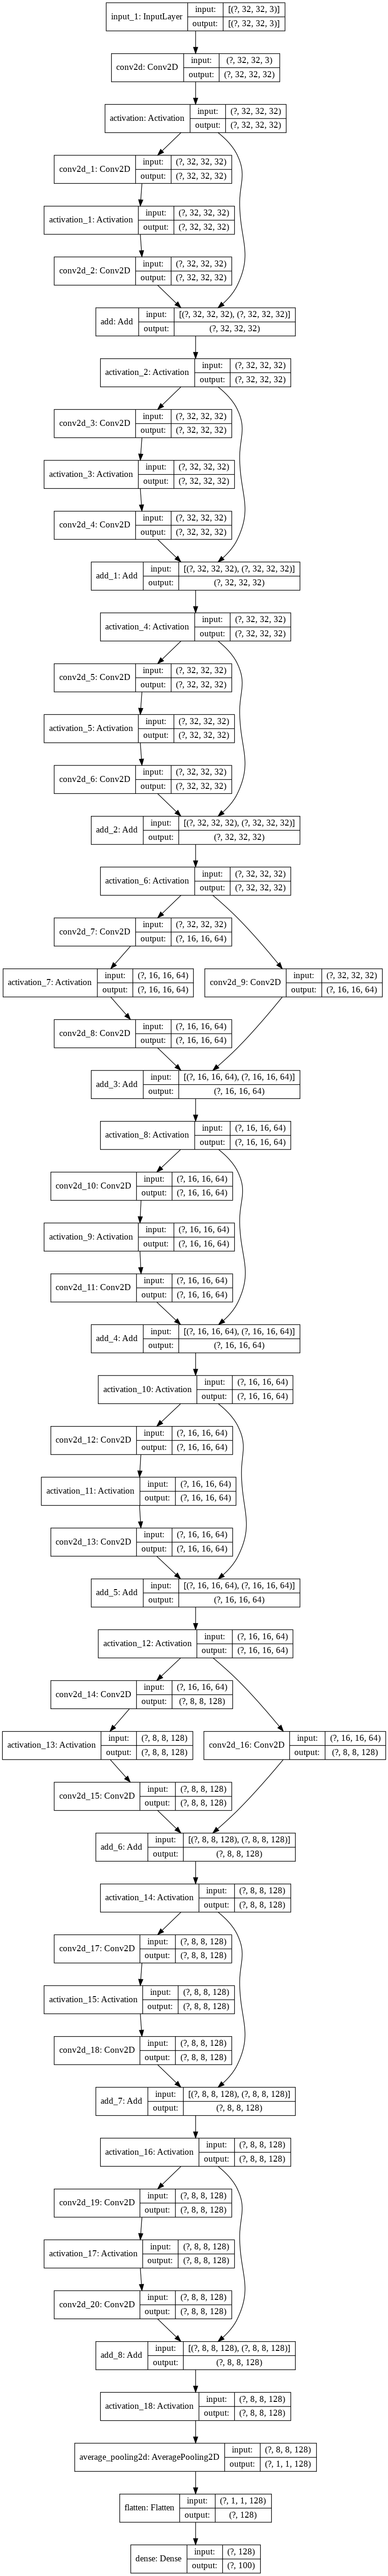

In [ ]:
model = create_model()
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Learning rate 0.035 gave best results with decay 1e-5, accuracy dropped when lr/decay was increased
sgd = optimizers.SGD(lr=0.035, decay=1e-5,momentum=0.8)
adam = optimizers.Adam(lr=0.0006, decay = 1e-3,clipvalue=0.5) #use epoch around 180
model.compile(loss='categorical_crossentropy', optimizer=adam,metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',min_delta=0.0001,patience=10,mode='max')
checkpoint_path = "ResNet18_ADAM_NoRegularization"
best_model = ModelCheckpoint(filepath = checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max')
# batch size to 128 for best accuracy, it decreases if batch size is increased
history = model.fit(x_train, y_train,
                    batch_size= 128,
                    epochs=150,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping,best_model],verbose=2)

Epoch 1/150
391/391 - 18s - loss: 4.2202 - accuracy: 0.0434 - val_loss: 3.8998 - val_accuracy: 0.0837
Epoch 2/150
391/391 - 18s - loss: 3.7256 - accuracy: 0.1138 - val_loss: 3.5703 - val_accuracy: 0.1532
Epoch 3/150
391/391 - 18s - loss: 3.3938 - accuracy: 0.1818 - val_loss: 3.2741 - val_accuracy: 0.2114
Epoch 4/150
391/391 - 18s - loss: 3.1001 - accuracy: 0.2373 - val_loss: 3.0257 - val_accuracy: 0.2538
Epoch 5/150
391/391 - 18s - loss: 2.8818 - accuracy: 0.2815 - val_loss: 2.8778 - val_accuracy: 0.2876
Epoch 6/150
391/391 - 18s - loss: 2.6993 - accuracy: 0.3148 - val_loss: 2.7080 - val_accuracy: 0.3211
Epoch 7/150
391/391 - 18s - loss: 2.5463 - accuracy: 0.3459 - val_loss: 2.6915 - val_accuracy: 0.3221
Epoch 8/150
391/391 - 18s - loss: 2.4189 - accuracy: 0.3740 - val_loss: 2.5632 - val_accuracy: 0.3484
Epoch 9/150
391/391 - 18s - loss: 2.3078 - accuracy: 0.3968 - val_loss: 2.4855 - val_accuracy: 0.3633
Epoch 10/150
391/391 - 18s - loss: 2.2190 - accuracy: 0.4133 - val_loss: 2.4303 - 

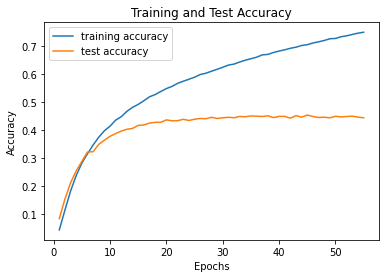

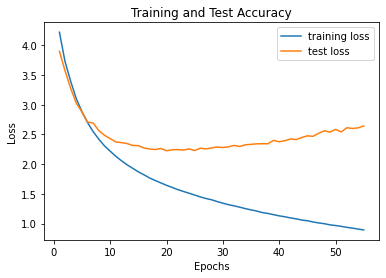

In [ ]:
#plot Accuracy vs epochs
train_metrics = history.history['accuracy']
val_metrics = history.history['val_accuracy']
epochs = range(1, len(train_metrics) + 1)
plt.plot(epochs, train_metrics)
plt.plot(epochs, val_metrics)
plt.title('Training and Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["training accuracy", 'test accuracy'])
plt.show()
#plot Validaiton loss vs epochs
train_metrics = history.history['loss']
val_metrics = history.history['val_loss']
plt.plot(epochs, train_metrics)
plt.plot(epochs, val_metrics)
plt.title('Training and Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training loss", 'test loss'])
plt.show()

In [ ]:
model = create_model()
# checkpoint_path = "../weights/ResNet18_ADAM_NoRegularization"
checkpoint_path = "ResNet18_ADAM_NoRegularization"
model.load_weights(checkpoint_path)
# loss,acc = model.evaluate(x_test,  y_test, verbose=2)
# print('Test Accuracy:', acc)
cm = confusion_matrix(y_test.argmax(axis=1), model.predict(x_test).argmax(-1))
print(cm)
precision = precision_score(y_test.argmax(axis=1), model.predict(x_test).argmax(-1), average='weighted')

accuracy= accuracy_score(y_test.argmax(axis=1), model.predict(x_test).argmax(-1))
recall= recall_score(y_test.argmax(axis=1), model.predict(x_test).argmax(-1), average='weighted')

print('precision:', precision)
print('accuracy:', accuracy)
print('recall:', recall)

[[70  1  0 ...  0  0  0]
 [ 0 62  0 ...  0  0  1]
 [ 0  1 39 ...  1  6  0]
 ...
 [ 0  0  0 ... 42  0  0]
 [ 0  1  8 ...  1 18  1]
 [ 1  1  0 ...  1  0 50]]
precision: 0.4500079847061923
accuracy: 0.4529
recall: 0.4529
